# Kolmogorov-Smirnov Test
Vinicius Trevisan 2022

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Multiclass classification evaluation with KS test

### Creating a synthetic dataset

In [3]:
scale = 3.5
size = 500

In [4]:
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [5]:
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

In [6]:
class3_x = np.random.normal(loc = 10, scale = scale, size = size)
class3_y = np.random.normal(loc = 10, scale = scale, size = size)

In [7]:
df_class1 = pd.DataFrame({'x' : class1_x, 'y' : class1_y, 'class': 'apple'})
df_class2 = pd.DataFrame({'x' : class2_x, 'y' : class2_y, 'class': 'banana'})
df_class3 = pd.DataFrame({'x' : class3_x, 'y' : class3_y, 'class': 'orange'})
df = df_class1.append(df_class2, ignore_index = True)
df = df.append(df_class3, ignore_index = True)

<AxesSubplot:xlabel='x', ylabel='y'>

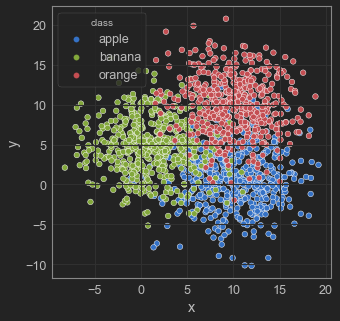

In [8]:
# Plot them to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df)

In [9]:
X = df[['x', 'y']]
y = df['class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fits the model and make the predictions

In [11]:
model_multiclass = RandomForestClassifier(n_estimators = 50, criterion = 'gini')

In [12]:
model_multiclass.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [13]:
y_pred = model_multiclass.predict(X_test)

In [14]:
y_proba = model_multiclass.predict_proba(X_test)

## One vs Rest (OvR)
Compares each class with the rest of the classes

In [15]:
classes = model_multiclass.classes_
classes

array(['apple', 'banana', 'orange'], dtype=object)

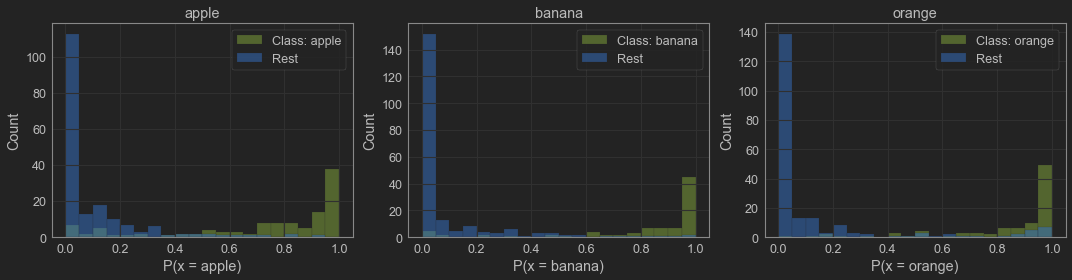

In [16]:
# Evaluates the KS Test for each class vs the rest
plt.figure(figsize = (15, 4))
bins = [i/20 for i in range(20)] + [1]
ks_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)    
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(1, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Recover each class
    class0 = df_aux[df_aux['class'] == 0]
    class1 = df_aux[df_aux['class'] == 1]
    
    # Calculates the KS OvR
    ks_ovr[c] = stats.ks_2samp(class0['prob'], class1['prob'])
    
plt.tight_layout()

In [17]:
# Displays the KS for each class
avg_ks = 0
i = 0
for k in ks_ovr:
    ks, pvalue = ks_ovr[k].statistic, ks_ovr[k].pvalue
    avg_ks += ks
    i += 1
    print(f"{k} KS OvR: {ks:.4f} (p-value = {pvalue:.3e})")
print(f"average KS OvR: {avg_ks/i:.4f}")

apple KS OvR: 0.7764 (p-value = 0.000e+00)
banana KS OvR: 0.8175 (p-value = 0.000e+00)
orange KS OvR: 0.8206 (p-value = 1.470e-48)
average KS OvR: 0.8048


## One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [18]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['apple', 'banana'],
 ['banana', 'apple'],
 ['apple', 'orange'],
 ['orange', 'apple'],
 ['banana', 'orange'],
 ['orange', 'banana']]

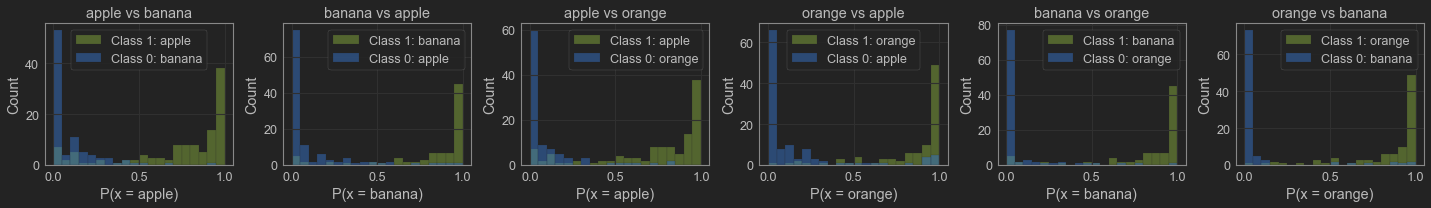

In [19]:
# Evaluates the KS Test for each combination of two distinct classes
plt.figure(figsize = (20, 3))
bins = [i/20 for i in range(20)] + [1]
ks_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " + c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(1, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Recover each class
    class0 = df_aux[df_aux['class'] == 0]
    class1 = df_aux[df_aux['class'] == 1]
    
    # Calculates the KS OvO
    ks_ovo[title] = stats.ks_2samp(class0['prob'], class1['prob'])
    
plt.tight_layout()

In [20]:
# Displays the KS for each class combination
avg_ks = 0
i = 0
for k in ks_ovo:
    ks, pvalue = ks_ovo[k].statistic, ks_ovo[k].pvalue
    avg_ks += ks
    i += 1
    print(f"{k} KS OvO: {ks:.4f} (p-value = {pvalue:.3e})")
print(f"average KS OvO: {avg_ks/i:.4f}")

apple vs banana KS OvO: 0.7918 (p-value = 1.149e-34)
banana vs apple KS OvO: 0.8125 (p-value = 3.680e-37)
apple vs orange KS OvO: 0.7704 (p-value = 6.528e-33)
orange vs apple KS OvO: 0.8003 (p-value = 2.356e-36)
banana vs orange KS OvO: 0.8357 (p-value = 0.000e+00)
orange vs banana KS OvO: 0.8894 (p-value = 0.000e+00)
average KS OvO: 0.8166
